In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

logger = logging.getLogger()

## Purpose and goal definition

In [2]:
X_data_directory = "../../data/histopathologic-cancer-detection/train/"
y_data_directory = "../../data/histopathologic-cancer-detection/train_labels.csv"

data_to_predict_directory = "../../data/histopathologic-cancer-detection/test"

In [3]:
y = pd.read_csv("../../data/histopathologic-cancer-detection/train_labels.csv")

In [4]:
y.shape

(220025, 2)

In [5]:
y.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Sort labels in alphanumeric order

In [6]:
y_sorted = y.sort_values('id')

In [7]:
y_sorted.head()

,id,label
151577,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
16166,000020de2aa6193f4c160e398a8edea95b1da598,0
87832,00004aab08381d25d315384d646f5ce413ea24b1,0
69359,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
128953,0000da768d06b879e5754c43e2298ce48726f722,1


In [8]:
y_sorted.tail()

,id,label
175454,fffe6c73afcf5f5da5818fb70cb723026b172eca,0
168161,fffeb3f5361ea57e728fb689e6be34d07d16ca7e,0
39707,fffeca85b16452a7709d163e05a70e646782b3cc,1
208140,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d,1
129173,ffffe55093358954f38bba4c35b6aa0ece86177c,0


### Preprocess labels so we'd be able to use them for loading and visualizing images 

In [9]:
y_sorted.loc[y_sorted['label'] == 0,'translated_label'] = 'False'
y_sorted.loc[y_sorted['label'] == 1,'translated_label'] = 'True'

y_sorted["file_name"] = y_sorted["id"].astype(str) + ".tif"

In [10]:
y_sorted.head()

,id,label,translated_label,file_name
151577,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1,True,00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
16166,000020de2aa6193f4c160e398a8edea95b1da598,0,False,000020de2aa6193f4c160e398a8edea95b1da598.tif
87832,00004aab08381d25d315384d646f5ce413ea24b1,0,False,00004aab08381d25d315384d646f5ce413ea24b1.tif
69359,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0,False,0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
128953,0000da768d06b879e5754c43e2298ce48726f722,1,True,0000da768d06b879e5754c43e2298ce48726f722.tif


### Lets explore our labels

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image. This is however not a requirement for the PCam benchmark.

In the original dataset the labels were balances between True and False and also contained information regarding the cancel in general (ie Is it cancerour? Is only the center canceros?). Kaggle removed that extra bit of information and in addition removed duplicates from the dataset.


In [11]:
y_sorted.count()

id                  220025
label               220025
translated_label    220025
file_name           220025
dtype: int64

We can see that there are indeed no duplicates, even after dropping duplications the data stayed the same.

In [12]:
y_sorted.drop_duplicates()

,id,label,translated_label,file_name
151577,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1,True,00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
16166,000020de2aa6193f4c160e398a8edea95b1da598,0,False,000020de2aa6193f4c160e398a8edea95b1da598.tif
87832,00004aab08381d25d315384d646f5ce413ea24b1,0,False,00004aab08381d25d315384d646f5ce413ea24b1.tif
69359,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0,False,0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
128953,0000da768d06b879e5754c43e2298ce48726f722,1,True,0000da768d06b879e5754c43e2298ce48726f722.tif
...,...,...,...,...
175454,fffe6c73afcf5f5da5818fb70cb723026b172eca,0,False,fffe6c73afcf5f5da5818fb70cb723026b172eca.tif
168161,fffeb3f5361ea57e728fb689e6be34d07d16ca7e,0,False,fffeb3f5361ea57e728fb689e6be34d07d16ca7e.tif
39707,fffeca85b16452a7709d163e05a70e646782b3cc,1,True,fffeca85b16452a7709d163e05a70e646782b3cc.tif
208140,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d,1,True,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d.tif


There are no duplicates based purely on image id either

In [13]:
y_sorted.groupby('id').filter(lambda x: len(x) > 1)

,id,label,translated_label,file_name


### Visualizing class labels distribution

<AxesSubplot:xlabel='translated_label', ylabel='count'>

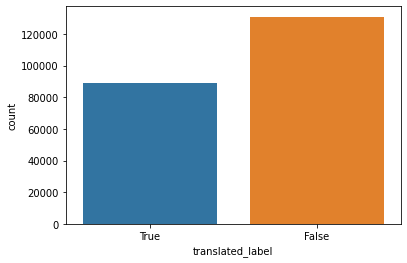

In [15]:
sns.countplot(data=y_sorted, x='translated_label')

We can see that after removing the duplications we have a bit of a skew between the labels. There are slightly more False labels than True labels. Lets look at the skew metric

In [16]:
y_sorted['label'].skew()

0.38692104417661555

We can see that the metric shows us that the labels distribution is fairly symmetrical. We'll keep it as is, and use oversampling in case we see problems with this balance in the future.

### Lets explore the data

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

In [17]:
file_name = y_sorted.iloc[[0]]['file_name'].iloc[0]
file_path = f"{X_data_directory}{file_name}"

img = plt.imread(file_path)

img.shape

(96, 96, 3)

From the shape we can see that our images are 96x96 with three color channels. Lets visualy some image and it's labels.

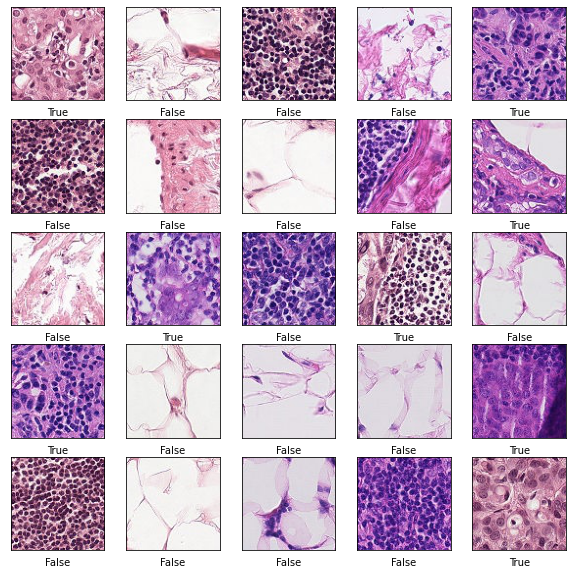

In [18]:
plt.figure(figsize=(10,10))

for i in range(25):
    current_row = y_sorted.iloc[[i]]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # get file name from cell
    current_file_name = current_row['file_name'].iloc[0]
    
    # concat to full path
    curr_file_path = f"{X_data_directory}{current_file_name}"
    
    try:
        img = plt.imread(curr_file_path)
        plt.imshow(img)

        plt.xlabel(current_row['translated_label'].iloc[0])
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()


## Exploring low/high contract images

## Load image train set

The data format we're dealing with here if tif. For this reason we can't use the image_dataset_from_directory provided by Keras. Instead we're going to use the ImageDataGenerator with

In [19]:
from keras.preprocessing.image import ImageDataGenerator

#### The image data generator is going to rescale the images, deviding them by 255 so that pixel value ranges between 0 and 1

In [41]:
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.3,
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip image

In [148]:
batch_size=1

In [149]:
train_set = datagen.flow_from_dataframe(
        dataframe=y_sorted,
        directory=X_data_directory,
        x_col='file_name',
        y_col='translated_label',
        shuffle=True,
        seed=42, 
        batch_size=batch_size,
        validation_split=0.3,
        subset="training",
        class_mode='binary') 

Found 154018 validated image filenames belonging to 2 classes.


In [150]:
val_set = datagen.flow_from_dataframe(
        dataframe=y_sorted,
        directory=X_data_directory,
        x_col='file_name',
        y_col='translated_label',
        shuffle=True,
        seed=42,
        batch_size=batch_size,
        validation_split=0.3,
        subset="validation",
        class_mode='binary') 

Found 66007 validated image filenames belonging to 2 classes.


### Determining the size of the batch
So at this point we've actually inncountered a bug with Keras, we got a pretty ugly exception if we'd set the batch size to be any number aside from 1. But then also not setting "steps_per_epoch" would put us in a bad position. 

Calculating the following metrics proves to be the samme as len(train_set). So using this setting the "steps_per_epoch" is running a single image per set per the entire dataset. 

In [151]:
train_steps_per_epoch = np.ceil(train_set.n / train_set.batch_size )

In [ ]:
train_steps_per_epoch

In [ ]:
len(train_set)

## Building our model

In [130]:
model = models.Sequential()
model.add(layers.Input(shape=(96, 96, 3)))

model.add(layers.Conv2D(16, (3, 3)))
model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization(axis = 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [131]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 batch_normalization_48 (Bat  (None, 94, 94, 16)       64        
 chNormalization)                                                
                                                                 
 activation_48 (Activation)  (None, 94, 94, 16)        0         
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 batch_normalization_49 (Bat  (None, 45, 45, 32)     

## Compiling and fitting our model

In [154]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_set, epochs=5, batch_size=1, steps_per_epoch=len(train_set),
                    validation_data=(val_set),verbose=1)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 73779/154018 [=============>................] - ETA: 9:14:02 - loss: 0.6754 - accuracy: 0.5943

Looking at the first epoch we've noticed the loss and accuracy don't really change afte raround 50-60K images